# Music vs. Speech classification using Neural Nets


The classification has been performed using GTZAN dataset and a feature matrix from:
https://github.com/jyotinarang2/Speech_Music_Classification/blob/master/gtzan_features.csv


Load keras and the other packages:

In [172]:
import keras
from __future__ import division # for Python 2.x

In [173]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessing the data
Load and display the data:

In [174]:
names = ['RMS','Spectral Slope','Zero Crossings','MFCC(2)','Spectral RollOff','MFCC(4)','MFCC(13)','MFCC(11)','MFCC(1)','MFCC(12)','Spectral Spread','Class']
df = pd.read_csv('https://raw.githubusercontent.com/jyotinarang2/Speech_Music_Classification/master/gtzan_features.csv',
                names=names,na_values='?',header=0)

df = df.dropna()
df.head(6)

,RMS,Spectral Slope,Zero Crossings,MFCC(2),Spectral RollOff,MFCC(4),MFCC(13),MFCC(11),MFCC(1),MFCC(12),Spectral Spread,Class
0,-20.187,-9.740000e-07,0.075458,2.2779,493,1.24320,0.095795,-0.128390,-25.954,-0.017165,616.68,'music'
1,-16.315,-2.270000e-06,0.098657,2.9004,462,0.36602,-0.339310,-0.050032,-22.565,-0.726760,878.82,'speech'
2,-21.369,-5.690000e-07,0.044689,2.3677,1184,0.75089,0.198910,0.214620,-27.885,0.434850,597.75,'music'
3,-17.724,-1.230000e-06,0.116730,1.8504,1170,0.72793,0.125660,0.197170,-23.188,0.333370,1250.10,'music'
4,-29.913,-4.980000e-07,0.094017,2.3898,561,1.44410,0.631700,-0.117360,-26.718,-0.440910,1015.50,'speech'
5,-14.613,-1.400000e-06,0.136750,1.4418,957,0.81468,0.315170,-0.548860,-23.978,0.122330,1283.50,'music'


Number of samples and features:

In [175]:
samples, features = df.shape
print("There are {0} samples with {1} features in the dataset.".format(samples, features-1))

There are 41344 samples with 11 features in the dataset.


Use 30000 samples for training and 11344 samples for testing

In [176]:
xnames =['RMS','Spectral Slope','Zero Crossings','MFCC(2)','Spectral RollOff',
         'MFCC(4)','MFCC(13)','MFCC(11)','MFCC(1)','MFCC(12)','Spectral Spread'] 

Xtr = np.array(df[xnames][:30000])
Xts = np.array(df[xnames][30000:])
ytr = np.array(df['Class'].values[:30000])
yts = np.array(df['Class'][30000:])

a,ytr = np.unique(ytr, return_inverse=True)
a,yts = np.unique(yts, return_inverse=True)


Scale the training set by subtracting its mean and dividing by standard deviation.
Scale the testing set subtracting the mean and dividing by the standard deviation of the training set.

In [177]:
# Scale the training and test matrices
mean = np.mean(Xtr, axis = 0)

std = np.std(Xtr, axis = 0)

Xtr_scale = (Xtr - mean) / std

Xts_scale = (Xts - mean) / std


In [178]:
# TODO
samples_tr, features_tr = np.shape(Xtr)
samples_ts, features_ts = np.shape(Xts)

num_labels = len(np.unique(yts))

print("Number of training and test samples: {0} and {1} accordingly.".format(samples_tr, samples_ts))
print("Number of features for each sample: {0}.".format(features_tr))
print("Number of classes (i.e. speech and music): {0}.".format(num_labels))

Number of training and test samples: 30000 and 11344 accordingly.
Number of features for each sample: 11.
Number of classes (i.e. speech and music): 2.


## Building a Neural Network Classifier

The following neural network `model` has:
* `nh=256` hidden units
* `sigmoid` activation


In [212]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation

In [220]:
# TODO clear session
import keras.backend as K
K.clear_session()

In [221]:
# TODO: construct the model
nin = Xtr_scale.shape[1]  # dimension of input data
nh = 500    # number of hidden units
nout = num_labels

model = Sequential()
model.add(Dense(nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(nout, activation='sigmoid', name='output'))

In [222]:
# TODO:  Print the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 400)               4800      
_________________________________________________________________
output (Dense)               (None, 2)                 802       
Total params: 5,602
Trainable params: 5,602
Non-trainable params: 0
_________________________________________________________________


To keep track of the loss history and validation accuracy, we will use a *callback* function as described in [Keras callback documentation](https://keras.io/callbacks/).  A callback is a class that is passed to the `fit` method.  Complete the `LoadHistory` callback class below to save the loss and validation accuracy.

In [223]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        # TODO:  Create two empty lists, self.loss and self.val_acc
        self.loss = []
        self.val_acc = []
 
    def on_batch_end(self, batch, logs={}):
        # TODO:  This is called at the end of each batch.  
        # Add the loss in logs.get('loss') to the loss list
        loss = logs.get('loss')
        self.loss.append(loss)
        
    def on_epoch_end(self, epoch, logs):
        # TODO:  This is called at the end of each epoch.  
        # Add the test accuracy in logs.get('val_acc') to the val_acc list
        val_acc = logs.get('val_acc')
        self.val_acc.append(val_acc)
        
        

# Create an instance of the history callback
history_cb = LossHistory()

Create an optimizer and compile the model.  Select the appropriate loss function and metrics.  For the optimizer, use the Adam optimizer with a learning rate of 0.001

In [224]:
# TODO

from keras import optimizers

opt = optimizers.Adam(lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


Fit the model for 10 epochs using the scaled data for both the training and validation.  Use the `validation_data` option to pass the test data.  Also, pass the callback class create above.  Use a batch size of 100.  Your final accuracy should be >99%.

In [225]:
# TODO
batch_size = 100
nepochs = 200
print("training...")
model.fit(Xtr_scale, ytr, 
          epochs=nepochs, 
          batch_size=100,
          verbose=0,
          validation_data=(Xts_scale,yts), 
          callbacks=[history_cb])


training...


Plot the validation accuracy saved in the `history_cb`. This gives one accuracy value per epoch.  You should see that the validation accuracy saturates at a little higher than 99%.  After that it "bounces around" due to the noise in the stochastic gradient descent.

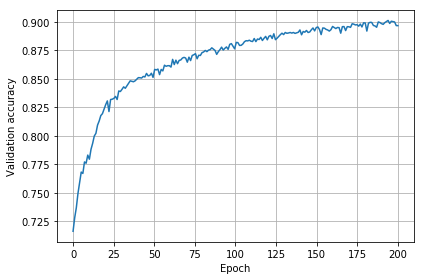

The accuracy of the classifier is 0.8967736267152391%.


In [226]:
# TODO
epoch_it = np.linspace(0,nepochs,len(history_cb.val_acc))

plt.plot(epoch_it, history_cb.val_acc)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.tight_layout()
plt.show()
print("The accuracy of the classifier is {0}%.".format(history_cb.val_acc[-1]))